In [45]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [46]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [47]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [48]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [49]:
ticker='TSLA'

In [50]:
df=df_dict[ticker].copy()
df

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2019-12-24,0.651907,27.890667,28.364668,27.512667,28.350000,120820500,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
1254,2019-12-26,0.643900,28.527332,28.898666,28.423332,28.729334,159508500,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
1255,2019-12-27,0.599764,29.000000,29.020666,28.407333,28.691999,149185500,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
1256,2019-12-30,0.503231,28.586000,28.600000,27.284000,27.646667,188796000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [51]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [52]:
dates = pd.to_datetime(df['Date'])

In [53]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [54]:
df_for_training = df[cols].astype(float)

In [55]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [56]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [57]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [58]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [59]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [60]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [61]:
print(X[0])

[[0.73349331 0.27521525 0.24356139 0.25310201 0.12313876 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 0.23172104 0.14147722 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 0.22138103 0.16859786 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.23535347]
 [0.60139272 0.24268824 0.21334812 0.24090432 0.0686182  1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.23420473]
 [0.7053284  0.24084322 0.20985233 0.24171053 0.08301029 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.23305598]
 [0.61846633 0.22755228 0.19622605 0.22400984 0.12022148 1.
  0.6     

In [62]:
print(X[1])

[[0.77183473 0.24678828 0.21948349 0.23172104 0.14147722 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 0.22138103 0.16859786 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.23535347]
 [0.60139272 0.24268824 0.21334812 0.24090432 0.0686182  1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.23420473]
 [0.7053284  0.24084322 0.20985233 0.24171053 0.08301029 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.23305598]
 [0.61846633 0.22755228 0.19622605 0.22400984 0.12022148 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.21927104]
 [0.6895419  0.20749626 0.17657131 0.2039958  0.15913872 1.
  0.6     

In [63]:
print(y[0])

[0.21088176]


In [64]:
def build_model(input_shape, output_shape):
    model=Sequential()
    model.add(Bidirectional(GRU(64,activation='relu',input_shape=input_shape,return_sequences=False)))
    model.add(Dense(output_shape))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')
    return model

early_stop=EarlyStopping(monitor='val_loss',patience=10)


Epoch 1/1000
4/4 [==============================] - 2s 88ms/step - loss: 0.0268 - val_loss: 0.0684
Epoch 2/1000
4/4 [==============================] - 0s 43ms/step - loss: 0.0195 - val_loss: 0.0556
Epoch 3/1000
4/4 [==============================] - 0s 42ms/step - loss: 0.0137 - val_loss: 0.0444
Epoch 4/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.0092 - val_loss: 0.0350
Epoch 5/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.0060 - val_loss: 0.0273
Epoch 6/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.0039 - val_loss: 0.0212
Epoch 7/1000
4/4 [==============================] - 0s 40ms/step - loss: 0.0027 - val_loss: 0.0165
Epoch 8/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.0021 - val_loss: 0.0130
Epoch 9/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.0020 - val_loss: 0.0105
Epoch 10/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.0021 - val_loss: 0.0087
Epoch 11/

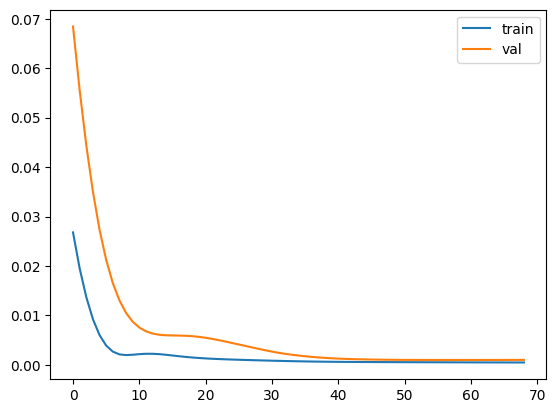

4/4 [==============================] - 0s 6ms/step
mae: 0.9162019952916508


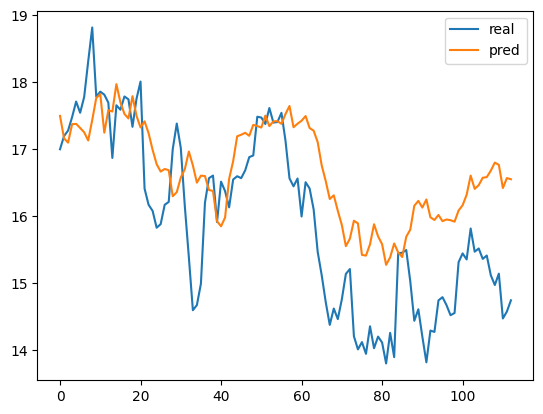

Epoch 1/1000
7/7 [==============================] - 2s 57ms/step - loss: 0.1135 - val_loss: 0.0746
Epoch 2/1000
7/7 [==============================] - 0s 34ms/step - loss: 0.0853 - val_loss: 0.0527
Epoch 3/1000
7/7 [==============================] - 0s 34ms/step - loss: 0.0623 - val_loss: 0.0351
Epoch 4/1000
7/7 [==============================] - 0s 37ms/step - loss: 0.0442 - val_loss: 0.0218
Epoch 5/1000
7/7 [==============================] - 0s 39ms/step - loss: 0.0306 - val_loss: 0.0125
Epoch 6/1000
7/7 [==============================] - 0s 33ms/step - loss: 0.0210 - val_loss: 0.0064
Epoch 7/1000
7/7 [==============================] - 0s 32ms/step - loss: 0.0147 - val_loss: 0.0029
Epoch 8/1000
7/7 [==============================] - 0s 31ms/step - loss: 0.0108 - val_loss: 0.0011
Epoch 9/1000
7/7 [==============================] - 0s 33ms/step - loss: 0.0086 - val_loss: 5.3537e-04
Epoch 10/1000
7/7 [==============================] - 0s 32ms/step - loss: 0.0075 - val_loss: 5.0996e-04
E

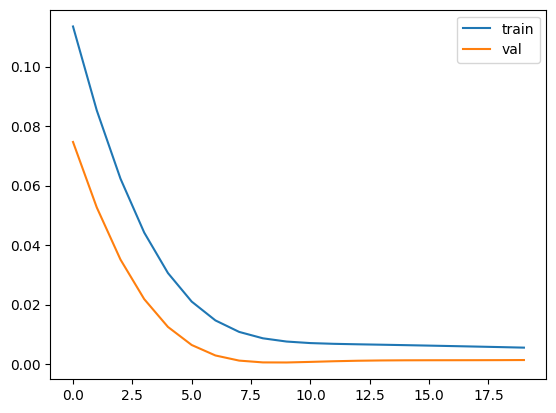

4/4 [==============================] - 0s 6ms/step
mae: 1.63123904208239


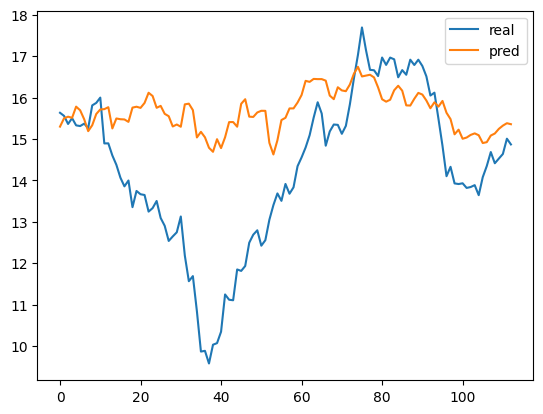

Epoch 1/1000
10/10 [==============================] - 2s 49ms/step - loss: 0.1300 - val_loss: 0.0850
Epoch 2/1000
10/10 [==============================] - 0s 35ms/step - loss: 0.0821 - val_loss: 0.0506
Epoch 3/1000
10/10 [==============================] - 0s 31ms/step - loss: 0.0488 - val_loss: 0.0271
Epoch 4/1000
10/10 [==============================] - 0s 31ms/step - loss: 0.0275 - val_loss: 0.0128
Epoch 5/1000
10/10 [==============================] - 0s 32ms/step - loss: 0.0156 - val_loss: 0.0054
Epoch 6/1000
10/10 [==============================] - 0s 31ms/step - loss: 0.0100 - val_loss: 0.0023
Epoch 7/1000
10/10 [==============================] - 0s 31ms/step - loss: 0.0078 - val_loss: 0.0012
Epoch 8/1000
10/10 [==============================] - 0s 34ms/step - loss: 0.0070 - val_loss: 9.9096e-04
Epoch 9/1000
10/10 [==============================] - 0s 32ms/step - loss: 0.0066 - val_loss: 9.3764e-04
Epoch 10/1000
10/10 [==============================] - 0s 32ms/step - loss: 0.0063 

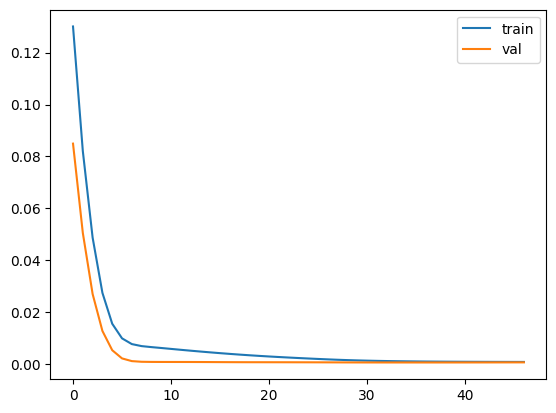

4/4 [==============================] - 0s 6ms/step
mae: 0.5116612789155403


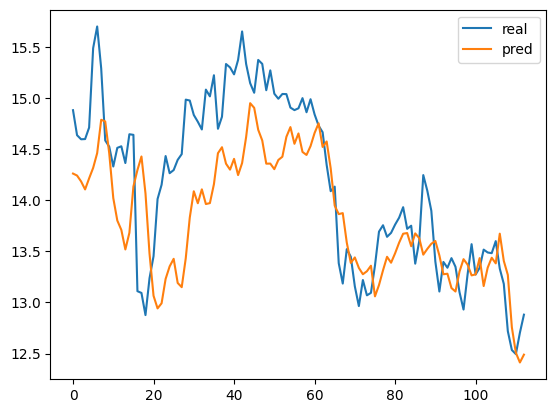

Epoch 1/1000
13/13 [==============================] - 2s 45ms/step - loss: 0.0476 - val_loss: 0.0069
Epoch 2/1000
13/13 [==============================] - 0s 31ms/step - loss: 0.0280 - val_loss: 0.0014
Epoch 3/1000
13/13 [==============================] - 0s 32ms/step - loss: 0.0158 - val_loss: 9.0469e-04
Epoch 4/1000
13/13 [==============================] - 0s 32ms/step - loss: 0.0093 - val_loss: 0.0031
Epoch 5/1000
13/13 [==============================] - 0s 30ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 6/1000
13/13 [==============================] - 0s 31ms/step - loss: 0.0054 - val_loss: 0.0069
Epoch 7/1000
13/13 [==============================] - 0s 31ms/step - loss: 0.0050 - val_loss: 0.0072
Epoch 8/1000
13/13 [==============================] - 0s 32ms/step - loss: 0.0047 - val_loss: 0.0068
Epoch 9/1000
13/13 [==============================] - 0s 30ms/step - loss: 0.0045 - val_loss: 0.0063
Epoch 10/1000
13/13 [==============================] - 0s 30ms/step - loss: 0.0043 - va

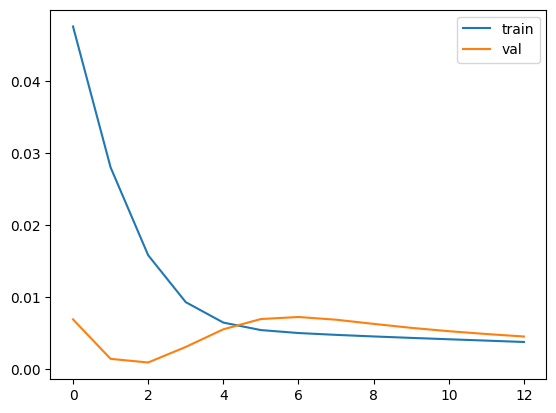

4/4 [==============================] - 0s 6ms/step
mae: 1.2728203288730862


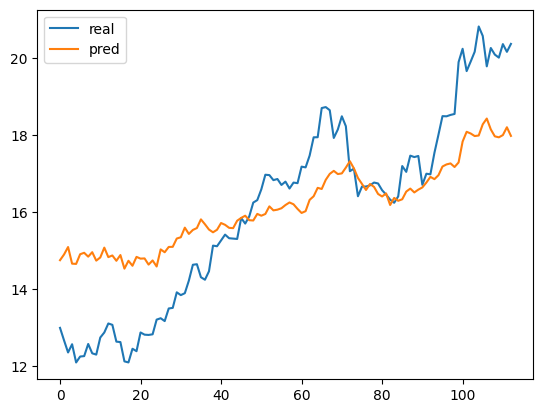

Epoch 1/1000
17/17 [==============================] - 2s 38ms/step - loss: 0.0556 - val_loss: 0.0584
Epoch 2/1000
17/17 [==============================] - 1s 31ms/step - loss: 0.0236 - val_loss: 0.0189
Epoch 3/1000
17/17 [==============================] - 1s 33ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 4/1000
17/17 [==============================] - 1s 33ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 5/1000
17/17 [==============================] - 1s 31ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 6/1000
17/17 [==============================] - 1s 30ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 7/1000
17/17 [==============================] - 1s 30ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 8/1000
17/17 [==============================] - 1s 31ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 9/1000
17/17 [==============================] - 1s 30ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 10/1000
17/17 [==============================] - 1s 31ms/step - loss: 0.0038 - val_lo

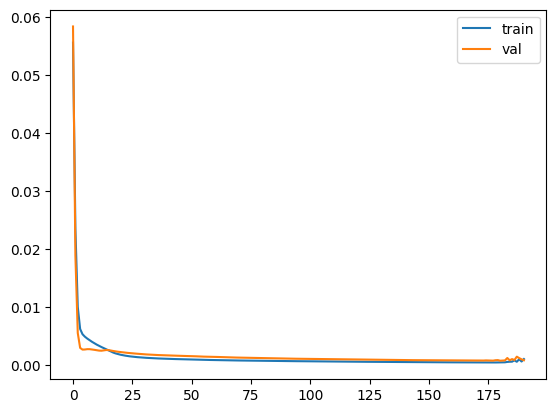

4/4 [==============================] - 0s 6ms/step
mae: 0.6315675537109379


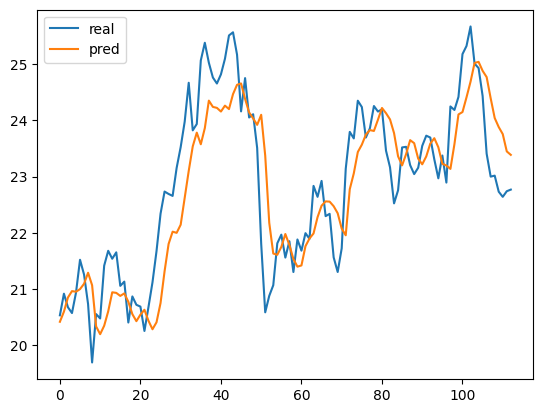

Epoch 1/1000
20/20 [==============================] - 2s 38ms/step - loss: 0.0431 - val_loss: 0.3023
Epoch 2/1000
20/20 [==============================] - 1s 33ms/step - loss: 0.0198 - val_loss: 0.2051
Epoch 3/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0141 - val_loss: 0.1554
Epoch 4/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0125 - val_loss: 0.1305
Epoch 5/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0113 - val_loss: 0.1150
Epoch 6/1000
20/20 [==============================] - 1s 33ms/step - loss: 0.0100 - val_loss: 0.1025
Epoch 7/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0089 - val_loss: 0.0909
Epoch 8/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0079 - val_loss: 0.0802
Epoch 9/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0070 - val_loss: 0.0706
Epoch 10/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0061 - val_lo

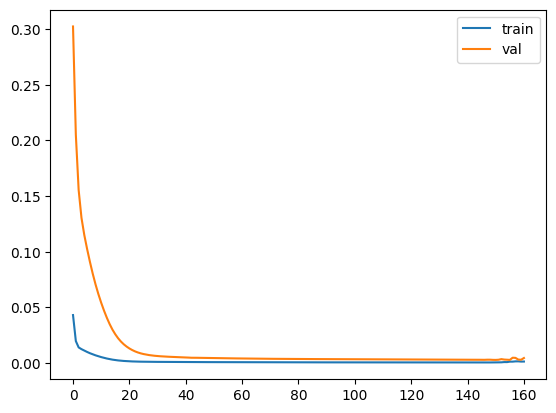

4/4 [==============================] - 0s 8ms/step
mae: 1.3169927977899871


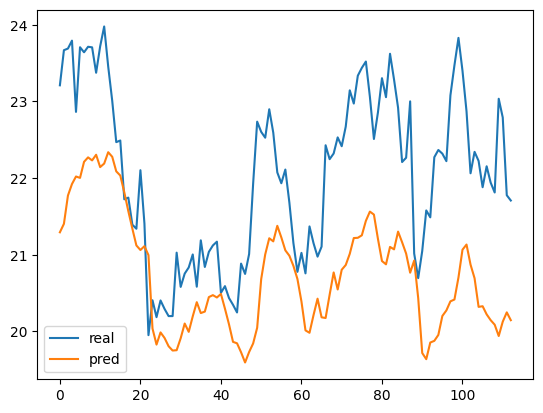

Epoch 1/1000
23/23 [==============================] - 2s 41ms/step - loss: 0.0631 - val_loss: 0.1098
Epoch 2/1000
23/23 [==============================] - 1s 39ms/step - loss: 0.0206 - val_loss: 0.0368
Epoch 3/1000
23/23 [==============================] - 1s 39ms/step - loss: 0.0111 - val_loss: 0.0135
Epoch 4/1000
23/23 [==============================] - 1s 35ms/step - loss: 0.0092 - val_loss: 0.0070
Epoch 5/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.0077 - val_loss: 0.0044
Epoch 6/1000
23/23 [==============================] - 1s 44ms/step - loss: 0.0063 - val_loss: 0.0029
Epoch 7/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 8/1000
23/23 [==============================] - 1s 52ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 9/1000
23/23 [==============================] - 1s 45ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 10/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.0035 - val_lo

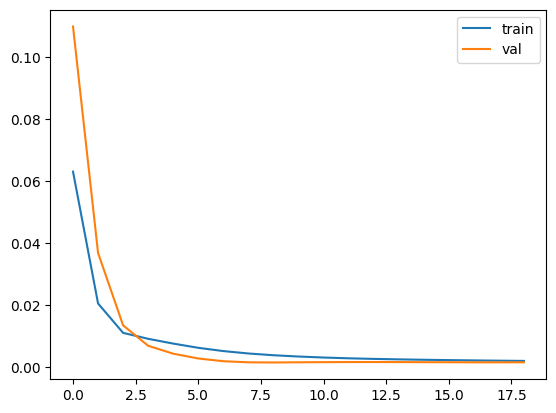

4/4 [==============================] - 0s 6ms/step
mae: 1.0403820125311118


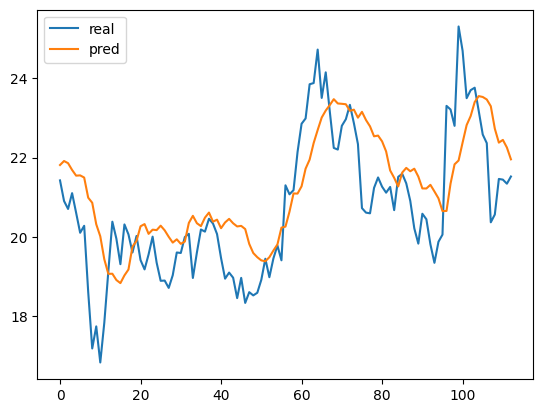

Epoch 1/1000
26/26 [==============================] - 3s 47ms/step - loss: 0.0947 - val_loss: 0.1251
Epoch 2/1000
26/26 [==============================] - 1s 40ms/step - loss: 0.0380 - val_loss: 0.0415
Epoch 3/1000
26/26 [==============================] - 1s 38ms/step - loss: 0.0205 - val_loss: 0.0143
Epoch 4/1000
26/26 [==============================] - 1s 38ms/step - loss: 0.0156 - val_loss: 0.0075
Epoch 5/1000
26/26 [==============================] - 1s 37ms/step - loss: 0.0132 - val_loss: 0.0062
Epoch 6/1000
26/26 [==============================] - 1s 38ms/step - loss: 0.0113 - val_loss: 0.0062
Epoch 7/1000
26/26 [==============================] - 1s 38ms/step - loss: 0.0097 - val_loss: 0.0065
Epoch 8/1000
26/26 [==============================] - 1s 40ms/step - loss: 0.0085 - val_loss: 0.0068
Epoch 9/1000
26/26 [==============================] - 1s 35ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 10/1000
26/26 [==============================] - 1s 31ms/step - loss: 0.0067 - val_lo

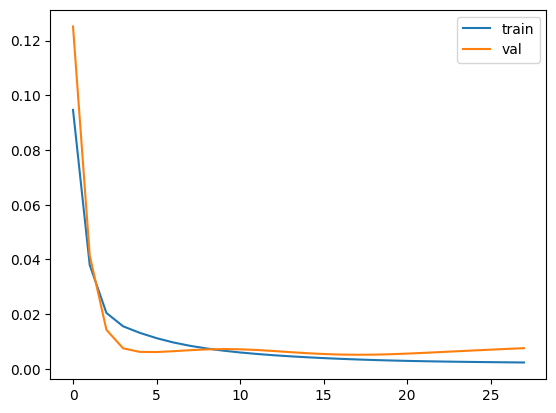

4/4 [==============================] - 0s 6ms/step
mae: 1.7870633548022241


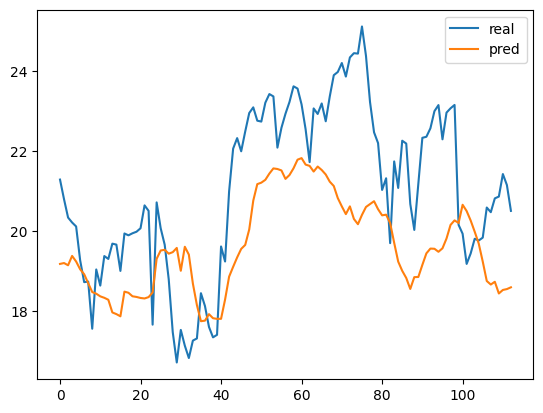

Epoch 1/1000
29/29 [==============================] - 3s 46ms/step - loss: 0.0438 - val_loss: 0.0228
Epoch 2/1000
29/29 [==============================] - 1s 39ms/step - loss: 0.0187 - val_loss: 0.0112
Epoch 3/1000
29/29 [==============================] - 1s 40ms/step - loss: 0.0162 - val_loss: 0.0145
Epoch 4/1000
29/29 [==============================] - 1s 41ms/step - loss: 0.0133 - val_loss: 0.0152
Epoch 5/1000
29/29 [==============================] - 1s 38ms/step - loss: 0.0109 - val_loss: 0.0160
Epoch 6/1000
29/29 [==============================] - 1s 37ms/step - loss: 0.0092 - val_loss: 0.0162
Epoch 7/1000
29/29 [==============================] - 1s 40ms/step - loss: 0.0078 - val_loss: 0.0159
Epoch 8/1000
29/29 [==============================] - 1s 40ms/step - loss: 0.0067 - val_loss: 0.0154
Epoch 9/1000
29/29 [==============================] - 1s 39ms/step - loss: 0.0058 - val_loss: 0.0146
Epoch 10/1000
29/29 [==============================] - 1s 38ms/step - loss: 0.0052 - val_lo

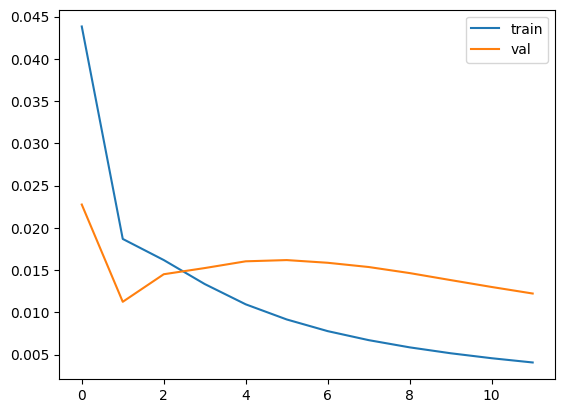

4/4 [==============================] - 0s 9ms/step
mae: 3.166039047521


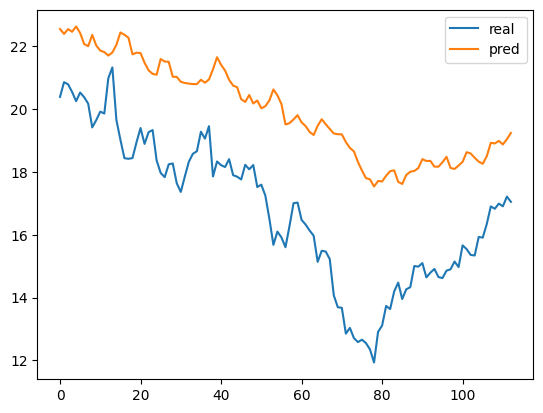

Epoch 1/1000
32/32 [==============================] - 2s 22ms/step - loss: 0.1799 - val_loss: 0.0545
Epoch 2/1000
32/32 [==============================] - 0s 15ms/step - loss: 0.0516 - val_loss: 0.0037
Epoch 3/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0145 - val_loss: 0.0202
Epoch 4/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.0080 - val_loss: 0.0350
Epoch 5/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0072 - val_loss: 0.0365
Epoch 6/1000
32/32 [==============================] - 0s 15ms/step - loss: 0.0068 - val_loss: 0.0342
Epoch 7/1000
32/32 [==============================] - 1s 17ms/step - loss: 0.0064 - val_loss: 0.0319
Epoch 8/1000
32/32 [==============================] - 0s 15ms/step - loss: 0.0059 - val_loss: 0.0295
Epoch 9/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.0054 - val_loss: 0.0267
Epoch 10/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0049 - val_lo

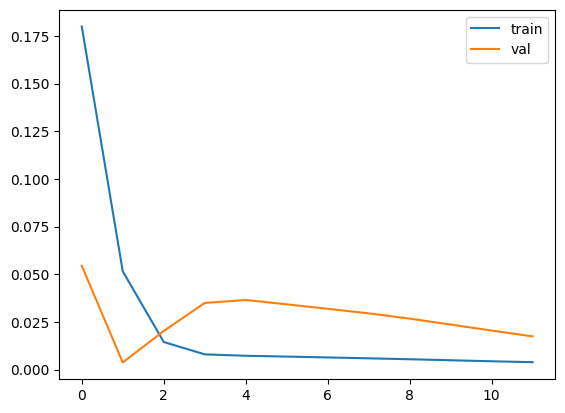

4/4 [==============================] - 0s 5ms/step
mae: 2.2167726920857387


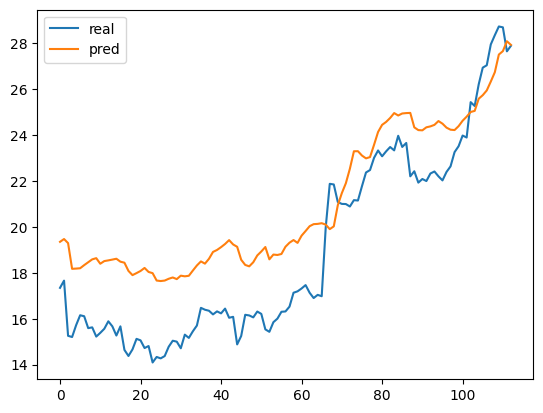

In [65]:
tscv = TimeSeriesSplit(n_splits=10)
maes=[]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.9)  # Adjust the validation split percentage as needed
    X_train, x_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    model=build_model(input_shape=(X_train.shape[1],X_train.shape[2]),output_shape=y_train.shape[1])
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    mae=np.mean(np.abs(pred-y_test))
    maes.append(mae)
    print('mae:',mae)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()



In [66]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_29 (Bidirect  (None, 128)               31872     
 ional)                                                          
                                                                 
 dense_29 (Dense)            (None, 1)                 129       
                                                                 
Total params: 32001 (125.00 KB)
Trainable params: 32001 (125.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
average_mae=np.mean(maes)
print('average mae:',average_mae)

average mae: 1.4490740103603668
